Only on Google Colab, first run this code cell:

In [ ]:
! git clone https://github.com/compomics/workshop-ml-proteomics
! cp workshop-ml-proteomics/* . -r
! pip install -q deeplc pyteomics spectrum_utils ms2pip

Always run this one:

In [1]:
import matplotlib.pyplot as plt
import spectrum_utils.plot as sup
from pyteomics.mass import calculate_mass

from scripts.ms2pip_utils import get_usi_spectrum, get_theoretical_spectrum, get_predicted_spectrum, get_intensity_array

# 1 Peptide spectrum prediction with MS²PIP

## 1.1 Observed and theoretical peptide fragmentation spectra

The intact mass of a peptide does not provide sufficient information to identify it in a complex sample. For instance, the peptides `ACDEK` and `EDCAK` share the same amino acid composition and have the exact same mass. As a result, these peptides are indistinguishable based on their intact mass alone (they are isomeric). More information on the peptide is therefore required.

Through peptide fragmentation, we can break a peptide into various fragment ions, each representing a part of the peptide sequence. Fragmentation takes place in the collision cell of the mass spectrometer and can be performed by colliding the peptides with an inert gas, such as argon. The resulting fragment ions are then acquired in the MS2 scan, making up the peptide fragmentation spectrum.

![LC-MS DDA overview](./images/1.1-lcms-dda-overview.png)

_Overview of a data-dependent mass spectrometry workflow with peptide fragmentation._

Using the Universal Spectrum Identifier<sup>[1]</sup>, we can directly download spectra from the PRIDE Archive. This spectrum was identified as peptide `VLHPLEGAVVIIFK` with precursor charge 2:

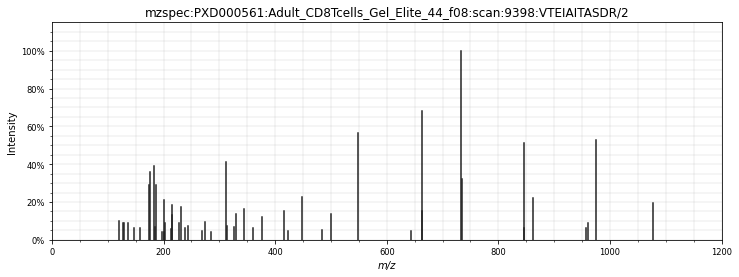

In [2]:
usi = "mzspec:PXD000561:Adult_CD8Tcells_Gel_Elite_44_f08:scan:9398:VTEIAITASDR/2"
observed_spectrum = get_usi_spectrum(usi)

plt.figure(figsize=(12,4))
plt.title(usi)
sup.spectrum(observed_spectrum)
plt.show()

**How do we know that this is the spectrum for peptide `VTEIAITASDR`?**

The most common fragment ion types from the _HCD_ and _CID_ fragmentation techniques are "b" and "y" ions. Each of these ions are the result of "breaking" the peptide in two parts. Depending on the location of the breakage along the peptide backbone, different b- or y-ion will be generated:

![image](https://www.bioinfor.com/wp-content/uploads/2016/11/denovo-screenshot.png)

_Figure 1.2 Example of peptide fragmentation._

As we know the masses of each amino acid, we can simply calculate the mass of each expected b- and y-ion for any given peptide:
- b-ions: Sum the masses of all amino acid residues and the mass of a proton
- y-ions: Sum the masses of all amino acid residues and add the mass of a proton and H<sub>2</sub>O.

Using these formulae, we can calculate a full _theoretical fragmentation spectrum_. Such a spectrum shows us where to expect peaks and where not. This information helps us to identify an MS2 spectrum. The theoretical spectrum for our downloaded spectrum from PRIDE Archive would contain the following b-ions:

In [3]:
peptide = "VTEIAITASDR"

for i, amino_acid in enumerate(peptide[:-1]):
    ion_mass = calculate_mass(sequence=peptide[:i+1], ion_type="b", charge=1)
    print(f"b{i+1}\t{ion_mass:.2f} Da\t", peptide[:i+1])

b1	100.08 Da	 V
b2	201.12 Da	 VT
b3	330.17 Da	 VTE
b4	443.25 Da	 VTEI
b5	514.29 Da	 VTEIA
b6	627.37 Da	 VTEIAI
b7	728.42 Da	 VTEIAIT
b8	799.46 Da	 VTEIAITA
b9	886.49 Da	 VTEIAITAS
b10	1001.51 Da	 VTEIAITASD


The full theoretical spectrum looks like this:

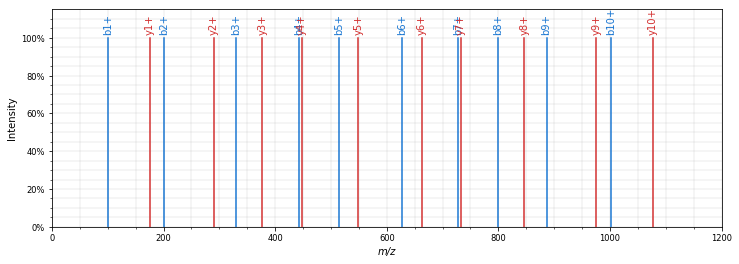

In [4]:
theoretical_spectrum = get_theoretical_spectrum("VTEIAITASDR", modifications="-")

plt.figure(figsize=(12,4))
sup.spectrum(theoretical_spectrum)
plt.show()

_Question 1.1: Run the code cell below. Often, a theoretical spectrum is instead visualized like the one below, why would that be?_

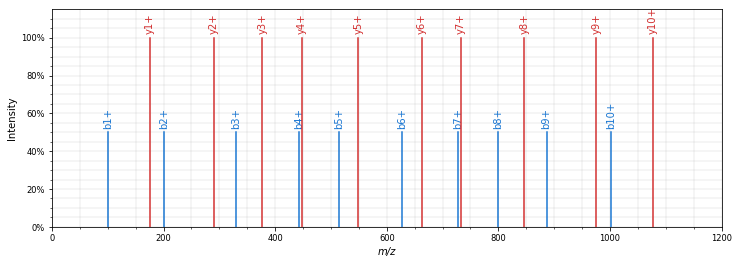

In [5]:
theoretical_spectrum = get_theoretical_spectrum("VTEIAITASDR", modifications="-", b_ion_weight=0.5)

plt.figure(figsize=(12,4))
sup.spectrum(theoretical_spectrum)
plt.show()

By matching an observed spectrum - such as the one downloaded before - with a theoretical spectrum, we can assess the probability that the peptide-to-spectrum match (PSM) is correct:

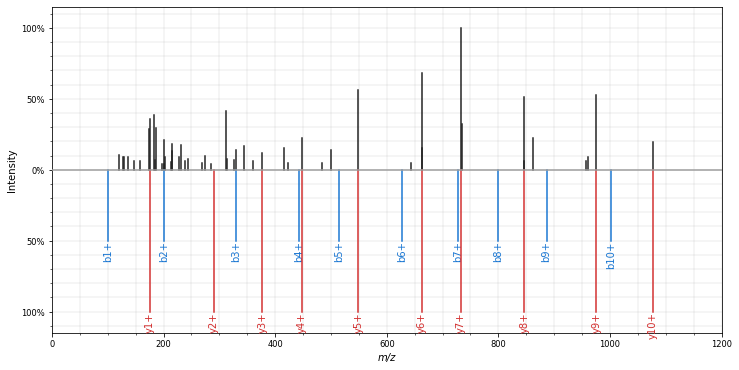

In [6]:
plt.figure(figsize=(12,6))
sup.mirror(observed_spectrum, theoretical_spectrum)
plt.show()

We can also annotate the observed spectrum accordingly:

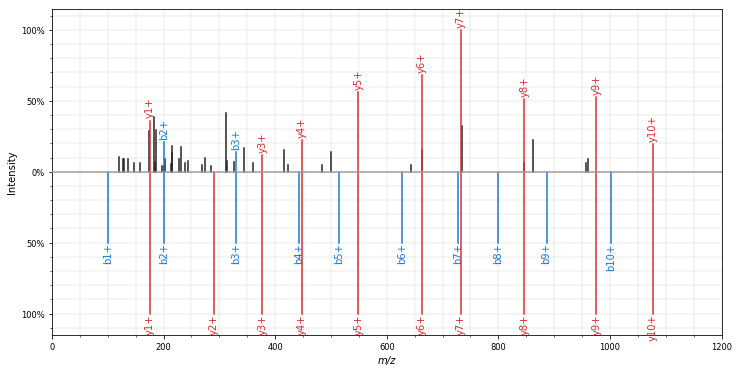

In [7]:
observed_spectrum.annotate_peptide_fragments(0.02, "Da")

plt.figure(figsize=(12,6))
sup.mirror(observed_spectrum, theoretical_spectrum)
plt.show()

_Question 1.2: In the above code, what would the `0.02 Da` mean? Why is this important?_

How well do the spectra match? Are all peaks matched? Are all peaks as intense as you would expect?


## 1.2 Predicted peptide fragmentation spectra

As you probably noticed, while we can simply calculate the fragment ion _m/z_ values for any given peptide, the resulting theoretical spectrum does not really resemble an observed spectrum. Many peaks are not as intense, many others are not present at all. Unfortunately, we cannot simply calculate the expected intensity of fragment ion peaks. This is where more complex models are required; models that can be learned from thousands or millions of observed fragmentation spectra with machine learning (ML).

MS²PIP<sup>[3]</sup> employs the XGBoost library, which is an advanced ML algorithm based decision trees. For each input - a peptide amino acid sequence - MS²PIP calculates meaningful features for the peptide and each fragment ion, derived from amino acid properties such as basicity, hydrophobicity, and isoelectric point. These features are then passed to the XGBoost algorithm, either to train new intensity prediction models, or to use existing models to make predictions. The output from MS²PIP is then a predicted spectrum with intensities that approximate true, observed fragmentation spectra:

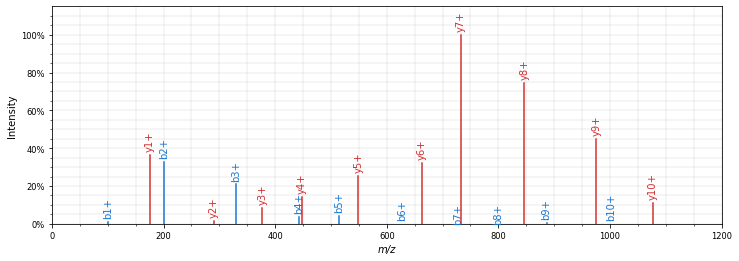

In [8]:
predicted_spectrum = get_predicted_spectrum("VTEIAITASDR", modifications="-", charge=2)

plt.figure(figsize=(12,4))
sup.spectrum(predicted_spectrum)
plt.show()

Let's compare it to the observed spectrum:

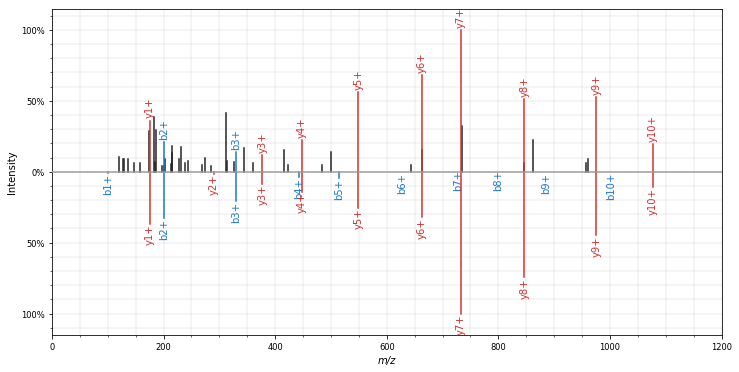

In [10]:
plt.figure(figsize=(12,6))
sup.mirror(observed_spectrum, predicted_spectrum)
plt.show()

As you can see, this is a much closer resemblance to the observed spectrum than the simple theoretical spectrum was. The brilliant aspect of spectrum prediction, is that you can run it for ANY peptide, even peptides that have not been observed before. If you don't have any non-amino acid characters (B, J, O, U, X, or Z)  in your name, fill it in below, and let's see what your peptide looks like!

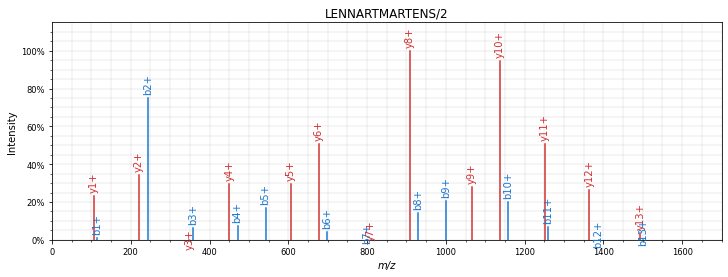

In [11]:
your_name = "LENNARTMARTENS"  # <-- Fill in your name here
charge = 2                    # <-- Try different precursor charge states (positive values, e.g. between 2 and 6)

predicted_spectrum = get_predicted_spectrum(your_name, modifications="-", charge=charge)

plt.figure(figsize=(12,4))
plt.title(your_name + "/" + str(charge))
sup.spectrum(predicted_spectrum)
plt.show()

# 2 Retention time prediction with DeepLC

In [ ]:
import pandas as pd
import seaborn as sns
from deeplc import DeepLC
from matplotlib import pyplot as plt

# Suppress tensorflow logging
import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

## 2.0 Introduction

**High Performance/Pressure Liquid Chromatography**

As all data acquisition parts in LC-IM-MS the LC part separates analytes. In this case the separation is based on the physicochemical properties of our peptides. In most cases peptides are separated based on their hydrophobicity in so-called reverse-phase LC.
A more detailed explanation can be found [here](https://www.ssi.shimadzu.com/products/liquid-chromatography/knowledge-base/hplc-basics.html).

This schematic representation of the instrument is the nightmare of every mass spectrometrist (i.e., this instrument is very prown to break):

![workflow_lc](https://cdn.technologynetworks.com/tn/images/body/lcfigure11608121500011.png)

_Adapted from [technologynetworks.com](https://www.technologynetworks.com/analysis/articles/liquid-chromatography-including-hplc-uhplc-and-lcxlc-344048)_

<br>

**Mobile and stationary phase; migration through the column**

In HPLC the separation happens in a column:

<img src="https://www.waters.com/content/dam/waters/en/Photography/Products/consumables/columns/symmetry-columns-family.jpg.thumb.319.319.png" alt="column" width="200"/>


This separation is achieved with two phases, the stationary phase can look like this:

<img src="https://2.bp.blogspot.com/-ICtYlU6RTu8/Wu756aCSE5I/AAAAAAAAHTw/YYXrCk-A7kAJyLEbDYEJzs0nl6M_P_gRQCLcBGAs/s320/c8-c18-column.jpg" alt="stationary" width="200"/>


The sample is pumped the column with two solvents that form the mobile phase (A and B):

<img src="https://www.ssi.shimadzu.com/sites/ssi.shimadzu.com/files/Products/Images/hplc/knowledge-base/hplc-screening-gradients-1.png" alt="mobile" width="200"/>


The analytes in the sample interact with both the stationary and mobile phase. The physicochemical properties of the peptides dictate how much they can interact with either of the two phases. (More) interaction with the mobile phase results in migration of the peptides in the column:
![workflow_lc](https://www.ssi.shimadzu.com/sites/ssi.shimadzu.com/files/Products/Images/hplc/knowledge-base/sample-bands-animation.gif)

Adapted from _[shimadzu.com](https://www.ssi.shimadzu.com/products/liquid-chromatography/knowledge-base/hplc-basics.html)_


## 2.1 DeepLC predictions

DeepLC<sup>[4]</sup> is a retention time predictor for (modified) peptides that employs deep learning. Its strength lies in the fact that it can accurately predict retention times for modified peptides, even if hasn’t seen said modification during training.


### 2.1.1 Reading data and preparing DeepLC

First we will read a table that contains all of our data:

In [ ]:
df = pd.read_csv("https://dl.dropboxusercontent.com/s/bok4w3jw2gxohbz/deeplc_input.csv",index_col=0)

The data looks like this:

In [ ]:
df

,scan,best_psm,database_peptide,modifications,precursor_mass,peptide_mass,rt,q_value
2,4,1,AGAVVGK,NaN,599.362768,600.359497,0.765235,0.706835
3,4,0,GAAAMGK,NaN,599.362768,604.300232,0.765235,0.768968
11,209,0,SAAAAAR,NaN,616.327734,616.329224,28.547861,0.679285
12,209,0,TQGSAAPGSK,3|semi_tryptic,616.327734,616.318054,28.547861,0.551056
13,209,1,GSETPGATPGSK,5|semi_tryptic,616.327734,616.318054,28.547861,0.089244
...,...,...,...,...,...,...,...,...
4452830,128083,1,SIEDYSQSIHTRTISGSPR,17|ethylamino,2160.093481,2160.092529,10516.730400,0.505389
4452832,128083,0,SIAASRFAPHIEKCIGMGR,8|Ala->Met|14|carbamidomethyl,2160.093481,2160.075684,10516.730400,0.668446
4452833,128083,0,SIAGFVASINEGMTRWFSR,13|Met->Tyr,2160.093481,2160.075195,10516.730400,0.516400
4452834,128083,0,SIAEAAMYWIVNWPRPQR,17|Gln->Thr,2160.093481,2160.093994,10516.730400,0.645799


We have multiple columns describing the scan number, if a PSM is the best ranked PSM, if there are any modifications, the precursor mass, the peptide mass, the observed retention time, and the associated q-value with the PSM.

For DeepLC we need strings instead of NaN in the modifications column, so lets replace those with empty strings:

In [ ]:
df.fillna("",inplace=True)

Here we sample rows from the original table, this is purely done for computational reasons (e.g., on a laptop). Feel free to increase the numbers if you have a faster system.

In [ ]:
num_total_rows_select = 5000
num_calib = 250

sub_df_pred = df[df["scan"].isin(list(set(df["scan"].sample(num_total_rows_select))))].copy()
sub_df_calib = sub_df_pred[sub_df_pred["scan"].isin(list(set(sub_df_pred[sub_df_pred["q_value"] < 0.01]["scan"].sample(num_calib))))].copy()

Here we make sure that the column names are changed to something that DeepLC recognizes:

In [ ]:
sub_df_pred.rename({
    "database_peptide" : "seq",
    "rt" : "tr"
},axis=1,inplace=True)

sub_df_calib.rename({
    "database_peptide" : "seq",
    "rt" : "tr"
},axis=1,inplace=True)

Initiate a DeepLC instance that will perform the calibration and predictions:

In [ ]:
dlc = DeepLC(
    cnn_model=True,
    pygam_calibration=False,
    verbose=False
)

We need to calibrate predictions to our specific LC setup to make them valid, so first we will feed some predictions to our DeepLC instance:

In [ ]:
dlc.calibrate_preds(seq_df=sub_df_calib[sub_df_calib["best_psm"]==1])

## 2.2 Prediction errors of (ranked) PSMs

### 2.2.1 Comparing rank 1 and lower ranked PSMs for the whole data set

Lets first make predictions:

In [ ]:
preds = dlc.make_preds(seq_df=sub_df_pred)
sub_df_pred["preds"] = preds

In the next cell we compare first-ranked PSMs against lower-ranked PSMs. It is immediately obvious that the lower-ranked PSMs have a wider error distribution. This highlights the possibility of rescoring PSMs in further analysis.

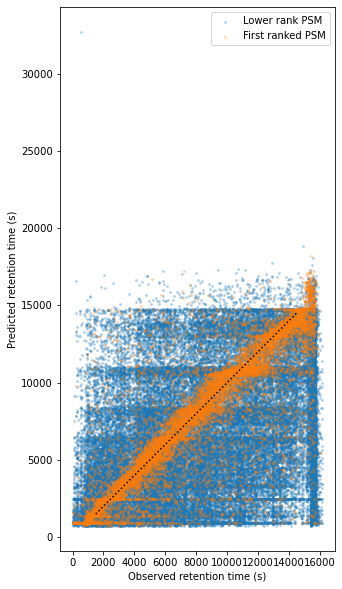

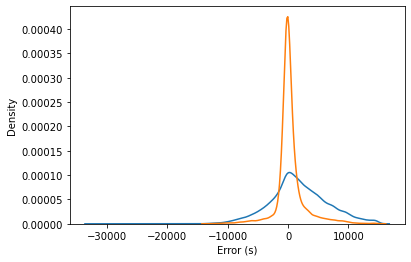

In [ ]:
sub_df_pred_lowerrank = sub_df_pred[sub_df_pred["best_psm"]==0]
sub_df_pred_firstrank = sub_df_pred[sub_df_pred["best_psm"]==1]

# Init plot
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.set_aspect('equal')

# Plot data
plt.scatter(sub_df_pred_lowerrank["tr"],sub_df_pred_lowerrank["preds"],s=3.5, alpha=0.25,label="Lower rank PSM")
plt.scatter(sub_df_pred_firstrank["tr"],sub_df_pred_firstrank["preds"],s=3.5, alpha=0.25,label="First ranked PSM")
plt.plot([1500,14500],[1500,14500],c="black",linestyle="dotted")

plt.xlabel("Observed retention time (s)")
plt.ylabel("Predicted retention time (s)")
plt.legend()

plt.show()

sns.distplot(sub_df_pred_lowerrank["tr"]-sub_df_pred_lowerrank["preds"],
             hist = False, kde = True, label="Lower rank PSM")
sns.distplot(sub_df_pred_firstrank["tr"]-sub_df_pred_firstrank["preds"],
             hist = False, kde = True, label="First ranked PSM")
plt.xlabel("Error (s)")
plt.show()

## 2.3 Predict retention times of modified peptides

### 2.3.1 Effect of modifications on retention time

In [ ]:
def plot_modification(sub_df_best,modification="carbamidomethyl"):
    # Init plot
    plt.figure(figsize=(7,7))
    ax = plt.gca()
    ax.set_aspect('equal')

    # Plot data
    plt.scatter(sub_df_best[sub_df_best["modifications"].str.contains(modification)]["tr"],sub_df_best[sub_df_best["modifications"].str.contains(modification)]["preds"],alpha=0.5,s=4)
    plt.plot([1500,14500],[1500,14500],c="black",linestyle="dotted")
    
    plt.title(modification)
    plt.xlabel("Observed retention time (s)")
    plt.ylabel("Predicted retention time (s)")
    
    plt.show()

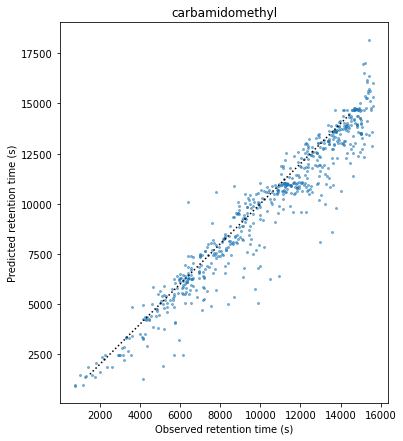

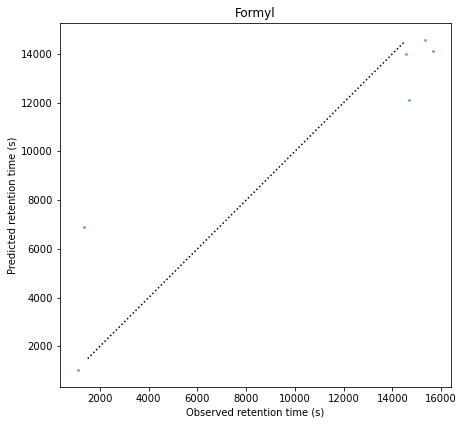

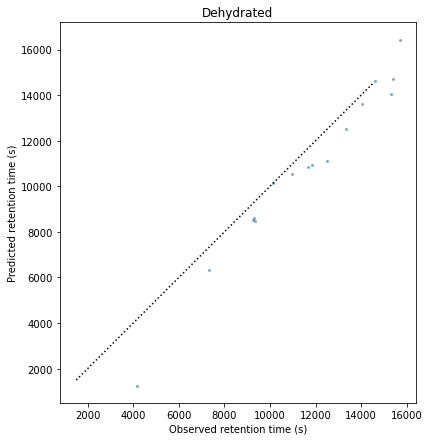

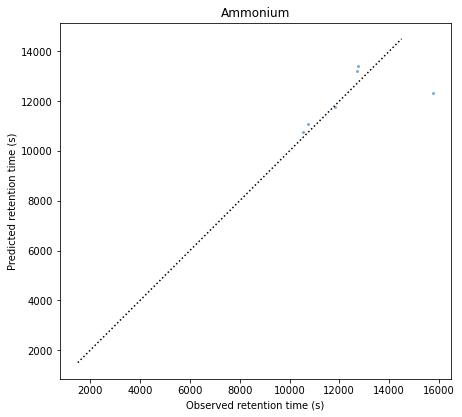

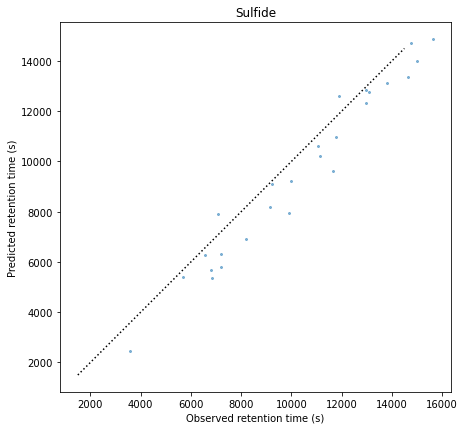

In [ ]:
sub_df_best = sub_df_pred[sub_df_pred["best_psm"]==1]
sub_df_best = sub_df_best[sub_df_best["q_value"]<0.001]

plot_modification(sub_df_best,modification="carbamidomethyl")
plot_modification(sub_df_best,modification="Formyl")
plot_modification(sub_df_best,modification="Dehydrated")
plot_modification(sub_df_best,modification="Ammonium")
plot_modification(sub_df_best,modification="Sulfide")

### References:
[1] Deutsch, E. W., Perez-Riverol, Y., Carver, J., Kawano, S. Mendoza, L., van den Bossche, T., Gabriels, R., Binz, P.-A., Pullman, B., Sun, Z., Shofstahl, J., Bittremieux, W., Mak, T. D., Klein, J., Zhu, Y., Lam, H., Vizcaíno, J. A., &#38; Bandeira, N. (2021). Universal Spectrum Identifier for mass spectra. <i>Nature Methods</i>, 1–3. https://doi.org/10.1038/s41592-021-01184-6

[2] Levitsky, L. I., Klein, J. A., Ivanov, M. v., &#38; Gorshkov, M. v. (2019). Pyteomics 4.0: Five Years of Development of a Python Proteomics Framework. <i>Journal of Proteome Research</i>, <i>18</i>(2), 709–714. https://doi.org/10.1021/ACS.JPROTEOME.8B00717/

[3] Gabriels, R., Martens, L., &#38; Degroeve, S. (2019). Updated MS<sup>2</sup>PIP web server delivers fast and accurate MS<sup>2</sup> peak intensity prediction for multiple fragmentation methods, instruments and labeling techniques. <i>Nucleic Acids Research</i>, <i>47</i>(W1), W295--W299. https://doi.org/10.1093/nar/gkz299

[4] Bouwmeester, R., Gabriels, R., Hulstaert, N., Martens, L., &#38; Degroeve, S. (2021). DeepLC can predict retention times for peptides that carry as-yet unseen modifications. <i>Nature Methods</i>, <i>18</i>(11), 1363–1369. https://doi.org/10.1038/s41592-021-01301-5